In [1]:
import sys
sys.path.insert(0, "../")

import pandas as pd
import torch
from torch.utils.data import DataLoader
import timm
from sklearn import manifold
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from src.utils import update_state_dict
from src.datasets.celeba import CelebADataset


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

val_dataset = CelebADataset("../../datasets/celeba/", "Male", 1)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    num_workers=2,
    pin_memory=use_cuda,
    shuffle=False,
)

In [9]:
ckpt_dir = "/home/jupyterlab/badr/logs/celeba_800979/checkpoint-019-0.900-0.560.ckpt"
ckpt = torch.load(ckpt_dir, map_location=device)

hparams = ckpt["hyper_parameters"]

state_dict = ckpt["state_dict"]
state_dict = update_state_dict(state_dict)

model = timm.create_model(
    model_name=hparams["model_name"],
    num_classes=hparams["num_classes"],
)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
hparams

{'device': 2,
 'max_epochs': 20,
 'save_dir': 'logs/',
 'model_name': 'resnet18',
 'num_classes': 1,
 'pretrained': True,
 'constrastive': True,
 'beta_metric_loss': 1.0,
 'temperature_metric_loss': 0.1,
 'dataset': 'celeba',
 'root_dir': '/home/jupyterlab/datasets',
 'spurious_label': 'Male',
 'stratified_sampling': True,
 'batch_size': 128,
 'num_workers': 2,
 'optimizer_name': 'SGD',
 'lr': 1e-05,
 'weight_decay': 1.0,
 'momentum': 0.9}

In [11]:
df = None
image_embeddings = []

model = model.to(device=device)
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader):
        filenames = batch.pop("filename")
        batch = {k: v.to(device=device) for k, v in batch.items()}
        x = batch["image"]
        g = batch["group"]
        s = batch["spurious_label"]
        y_true = batch["label"].float()
        if y_true.ndim < 2:
            y_true.unsqueeze_(1)

        logits = model(x)
        if logits.size(1) < 2:
            y_pred = (torch.sigmoid(logits) >= 0.5).float()
        else:
            y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1).unsqueeze(1)

        g = g.cpu()
        s = s.cpu()
        y_true = y_true.squeeze(1).cpu()
        y_pred = y_pred.squeeze(1).cpu()
        is_correct = (y_pred == y_true).cpu()

        if df is None:
            df = pd.DataFrame(
                torch.stack((g, y_true, y_pred, is_correct, s), dim=1),
                columns=["group", "y_true", "y_pred", "is_correct", "spurious_label"],
                dtype=int,
            )
            df["filename"] = filenames
        else:
            df_new = pd.DataFrame(
                torch.stack((g, y_true, y_pred, is_correct, s), dim=1),
                columns=["group", "y_true", "y_pred", "is_correct", "spurious_label"],
                dtype=int,
            )
            df_new["filename"] = filenames
            df = pd.concat((df, df_new), ignore_index=True)

        emb = model.global_pool(model.forward_features(x)).cpu()
        # emb = torch.nn.functional.normalize(emb, dim=1)
        image_embeddings.extend(emb)

image_embeddings = torch.stack(image_embeddings)

  0%|          | 0/156 [00:00<?, ?it/s]

In [12]:
df_uncorrect = df.loc[df["is_correct"] == 0]
df_uncorrect.reset_index(drop=True, inplace=True)


In [13]:
mani = manifold.TSNE()
compressed_image_embeddings = mani.fit_transform(image_embeddings[df_uncorrect.index, :])
x, y = np.split(compressed_image_embeddings, 2, 1)

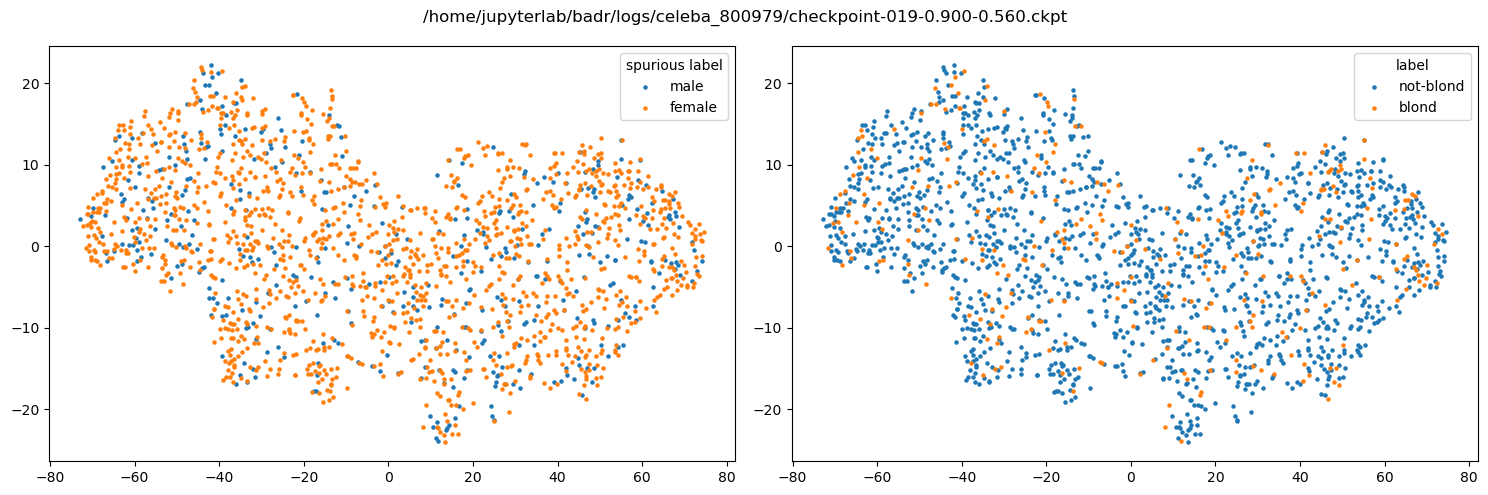

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in df_uncorrect["spurious_label"].unique():
    indices = df_uncorrect.loc[df_uncorrect["spurious_label"] == i].index
    ax[0].scatter(
        x[indices, :], y[indices, :],
        label="male" if i else "female",
        s=5,
    )
ax[0].legend(title="spurious label")

for i in df_uncorrect["y_true"].unique():
    indices = df_uncorrect.loc[df_uncorrect["y_true"] == i].index
    ax[1].scatter(
        x[indices, :], y[indices, :],
        label="blond" if i else "not-blond",
        s=5,
    )
ax[1].legend(title="label")

fig.suptitle(ckpt_dir)
fig.tight_layout()
plt.show()
